Source code: https://towardsdatascience.com/deeppicar-part-4-lane-following-via-opencv-737dd9e47c96 <br>
In the source code it uses blue colour lanes which allow for HSV colouring to be used, however, it seems that for our case the default BGR works better because our lane lines are black coloured. EDIT: After making the image only including Black and White through some image manipulation the YUV colour space was proven to be the best solution

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import statistics
import gc # Helps to clear up some ram

import cv2

import math
import os

import logging

In [4]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/trainImagesWithNoSigns.pickle","rb")
# Remove binary version
listOfIdsAndImagesWithNoRightOrLeftSign = pickle.load(pickle_in)

pickle_in = open(path+"/y_speed_gray.pickle","rb")
# Remove binary version
y_speed = pickle.load(pickle_in)

pickle_in = open(path+"/y_angle.pickle","rb")
# Remove binary version
y_angle = pickle.load(pickle_in)

pickle_in = open(path+"/image_id.pickle","rb")
# Remove binary version
imageId = pickle.load(pickle_in)
imageId = np.array(imageId)

In [5]:
from skimage import color, segmentation
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
from skimage.measure import regionprops
from skimage.future import graph
import networkx as nx

Turn the images to HSV colour to make it easier to distinguish the black lines

In [23]:
id, image = listOfIdsAndImagesWithNoRightOrLeftSign[6045]
#index 5777 was the picture that caused the most trouble (possibly there are more) id of the image is 3794
# also image id 13259 was causing touble with index 10248
# 9023 is a straight line, index 1703
# index 145 is causing too much trouble because it a crossroad

# Understand the area necessary to stop the car through comparison of index 4633 (id = 637), index 7958 (id = 222), 8295, 6045
height, _,_ = image.shape
#image = image[int(height/4):int(height/2.5),:,:]
image = image[int(height/2):,:,:]
#image = image[170//2:170,200:300,:]
print(image.shape)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(len(listOfIdsAndImagesWithNoRightOrLeftSign))

(120, 320, 3)
13082


In [ ]:
indx = np.where(image == 255)
print(indx)

(array([  0,   0,   0, ..., 219, 219, 222]), array([ 12,  12,  12, ..., 165, 181, 161]), array([0, 1, 2, ..., 2, 0, 2]))


In [ ]:
#print(image[0][12][0])

255


In [7]:
# write a function that takes the image, preprocesses it using the previous function we wrote and then uses the slic function to obtain the segmentation. It requires the number of segments and compactnesss to be set
def get_slic(img, n_segments, compactness):
  output = slic(img, n_segments, compactness)  #get segmentation 
  return output

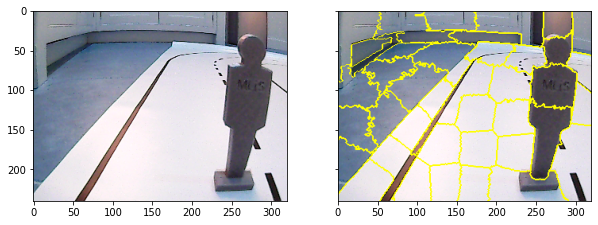

In [24]:
segs = get_slic(image, n_segments=50, compactness=10)
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(image);
ax[1].imshow(mark_boundaries(image, segs));

In [35]:
print(segs[100][50])
print(len(segs) )
print(len(segs[0]) )

14
240
320


In [10]:
g = graph.rag_mean_color(image,segs)

In [37]:
print('Nodes: \n', g.nodes) #print nodes
print('Degrees: \n', g.degree) #print number of degrees of each node (connections)
print('Edges: \n', g.edges) # print the connections
print('Node 0: \n', g.nodes[34]['mean color']) #print the properties of the nodes

Nodes: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Degrees: 
 [(0, 5), (1, 5), (2, 3), (3, 5), (4, 3), (5, 3), (6, 6), (7, 6), (8, 1), (9, 4), (10, 8), (11, 5), (12, 6), (13, 4), (14, 6), (15, 8), (16, 5), (17, 6), (18, 4), (19, 7), (20, 4), (21, 4), (22, 6), (23, 5), (24, 7), (25, 5), (26, 4), (27, 5), (28, 6), (29, 3), (30, 7), (31, 4), (32, 8), (33, 3), (34, 3), (35, 2), (36, 4), (37, 3), (38, 5)]
Edges: 
 [(0, 1), (0, 8), (0, 9), (0, 14), (0, 18), (1, 2), (1, 6), (1, 9), (1, 10), (2, 3), (2, 6), (3, 4), (3, 6), (3, 7), (3, 12), (4, 5), (4, 7), (5, 7), (5, 13), (6, 10), (6, 11), (6, 12), (7, 12), (7, 13), (7, 17), (9, 10), (9, 14), (10, 11), (10, 14), (10, 15), (10, 16), (10, 20), (11, 12), (11, 15), (11, 19), (12, 19), (12, 17), (13, 17), (13, 21), (14, 16), (14, 18), (14, 22), (15, 19), (15, 20), (15, 23), (15, 27), (15, 28), (15, 32), (16, 20), (16, 22), (16, 27), (17, 19), (1

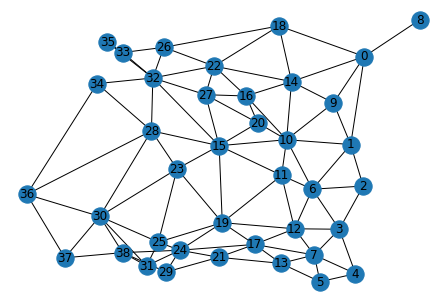

In [36]:
nx.draw(g, with_labels=True)

In [ ]:
len(g.nodes)

35

In [89]:
mean = []
for i in range(len(g.nodes)):
  mean.append( statistics.mean( g.nodes[i]['mean color']) )

Detect nodes that are mainly white (maybe include a requirement above that they should be connected if this is proven succesful)

In [41]:
indx_white = np.where(np.array(mean) > 200)
print(indx_white)

(array([11, 12, 13, 19, 20, 21, 23, 25, 27, 28, 29, 30, 31, 34, 35, 36, 37]),)


Now remember that segmentation categorizes each and every pixel, so we can find the rows and columns we want to remove based on the categorization of the segments

In [40]:
indx = np.where(np.array(segs) == indx_white[0][0])
indx = np.where(np.array(segs) == 30)
print(indx)

(array([151, 151, 151, ..., 197, 197, 198]), array([190, 191, 192, ..., 191, 192, 191]))


In [21]:
image = image[indx[0][0]:height,:,:]

396


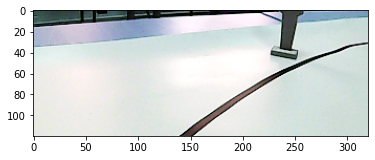

In [24]:
print(id)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.show()

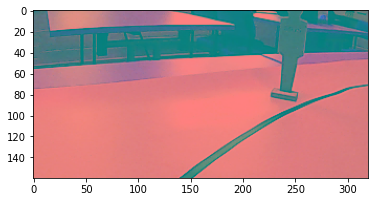

In [9]:
yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
plt.imshow(yuv)

In [10]:
yuv_new = yuv.copy()

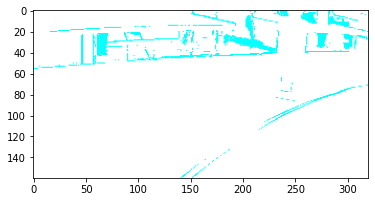

In [11]:
yuv_new[yuv_new >= 10] = 255
plt.imshow(yuv_new)
plt.show()

In [94]:
image_new = image.copy()

396


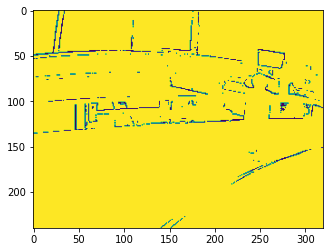

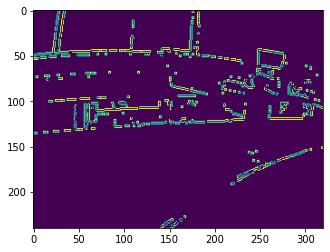

In [95]:
image_new[image_new >= 5] = 255
print(id)
# get rid of thinner lines
#kernel = np.ones((2,2),np.uint8)
#th1 = cv2.dilate(image_new,kernel,iterations = 1)

plt.imshow(image_new)
plt.show()
edges = cv2.Canny(image_new, 200, 400)
plt.imshow(edges)
plt.imshow(edges)

YUV was found to work better than keeping the image to its original form and it was better than HSV coulour space

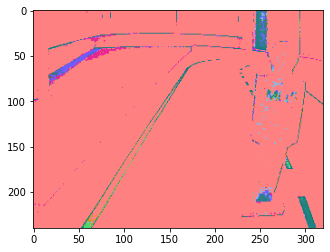

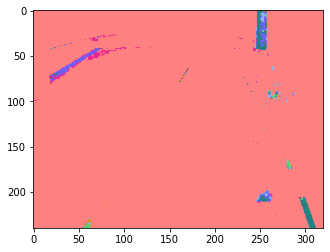

In [ ]:
yuv = cv2.cvtColor(image_new, cv2.COLOR_BGR2YUV)
plt.imshow(yuv)
plt.show()
yuv = cv2.cvtColor(th1, cv2.COLOR_BGR2YUV)
plt.imshow(yuv)
plt.show()

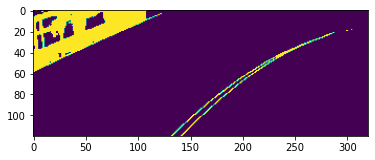

In [ ]:
lower_blue = np.array([0, 0, 0])
upper_blue = np.array([150, 255, 255])
#lower_blue = np.array([100,30,30])
#upper_blue = np.array([150,148,255])
#mask1 = cv2.inRange(image, lower_blue, upper_blue)
mask2 = cv2.inRange(yuv, lower_blue, upper_blue)
plt.imshow(mask2)

Detect edges

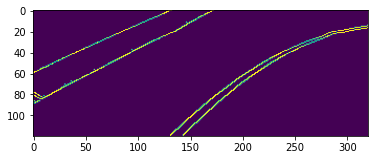

In [ ]:
edges = cv2.Canny(image, 200, 400)
plt.imshow(edges)

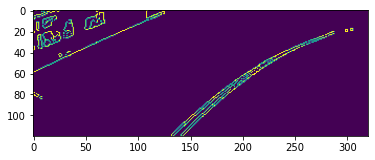

In [ ]:
edges = cv2.Canny(yuv, 200, 400)
plt.imshow(edges)

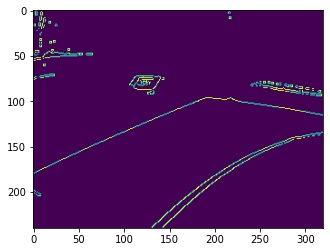

In [ ]:
edges = cv2.Canny(mask2, 200, 400)
plt.imshow(edges)

In [12]:
def detect_edges(frame):
    # filter for blue lane lines
    #height, _,_ = frame.shape
    #frame = frame[int(height/3):,:,:]
    image_new = frame.copy()
    #image_new[image_new >= 20] = 255
    yuv = cv2.cvtColor(image_new, cv2.COLOR_BGR2YUV)
    yuv_new = yuv.copy()
    yuv_new[yuv_new >= 10] = 255
    
    #show_image("hsv", hsv)
    #lower_blue = np.array([0, 0, 0])
    #upper_blue = np.array([150, 255, 255])
    #mask = cv2.inRange(yuv, lower_blue, upper_blue)
    #show_image("blue mask", mask)

    # detect edges
    #edges = cv2.Canny(mask, 200, 400)
    #edges = cv2.Canny(yuv_new, 200, 400)
    edges = cv2.Canny(image_new, 200, 400)

    return edges

In [13]:
def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)

    # only focus bottom half of the screen
    polygon = np.array([[
        (0, height * 1 / 2),
        (width, height * 1 / 2),
        (width, height),
        (0, height),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)
    return cropped_edges

In [14]:
def detect_line_segments(cropped_edges):
    # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1  # distance precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
    min_threshold = 10  # minimal of votes
    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    np.array([]), minLineLength=10, maxLineGap=2)
    # Default: minLineLength=8, maxLineGap=4

    return line_segments

In [20]:
def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        logging.info('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    #height, width = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2 or y1 ==y2: # Skip horizontal and vertical lines THIS HELPS A LOT
                logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines

In [19]:
def make_points(frame, line):
    height, width, _ = frame.shape
    #height, width = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down
  
    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

In [17]:
def detect_lane(frame):
    
    edges = detect_edges(frame)
    #cropped_edges = region_of_interest(edges)
    #line_segments = detect_line_segments(cropped_edges)
    line_segments = detect_line_segments(edges)
    lane_lines = average_slope_intercept(frame, line_segments)
    
    return lane_lines

In [25]:
lane_lines = detect_lane(image)
#lane_lines = detect_lane(th1)
#lane_lines = detect_lane(image_new)
#lane_lines = detect_lane(yuv_new)
#lane_lines = detect_lane(dil)
print(lane_lines)
print(len(lane_lines))

[[[12, 120, 169, 60]], [[616, 120, 325, 60]]]
2


In [ ]:
lane_lines[0][0]

[100, 55, 119, 27]

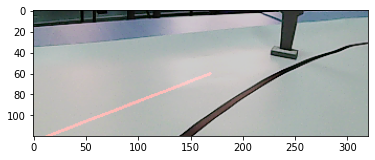

In [26]:
def display_lines(frame, lines, line_color=( 255), line_width=2):
# when 3 channel image make line_coloe = (0,255,0)
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image

lane_lines_image = display_lines(image, lane_lines)
#cv2.imshow("lane lines", lane_lines_image)
plt.imshow( lane_lines_image)

Match the images that we have with the correct speeds

In [ ]:
newImageTrainingSet = []
newImageId = []
new_ySpeed = []


for id, img in listOfIdsAndImagesWithNoRightOrLeftSign:
  index_id = np.where(imageId == id)
  newImageId.append(id)
  newImageTrainingSet.append(img)
  new_ySpeed.append(y_speed[index_id])

  # height, _,_ = img.shape
  # img = img[int(height/3):,:,:]

  # lane_lines = detect_lane(img)
  # if len(lane_lines) > 1:
  #   lane_lines.pop(1)
  # x1, y1, x2, y2 = lane_lines[0][0]

  # slope = round((y2-y1)/(x2-x1),3)
  # slopeOfLineDetected.append(slope)
  # test that everything will work
  #print(index_id)
  #print(newTrainingSet)
  #break

In [ ]:
inl = np.where(imageId == 1000)
#print(inl)
print(inl[0].shape[0])
print(inl[0][0])

1
12996


3794
146


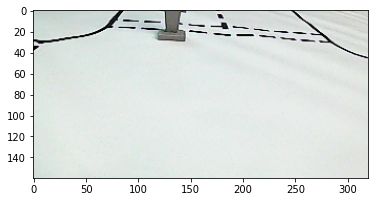

In [ ]:
plt.imshow(img)
print(id)
print(len(newImageId))

Get image, detect whether there is an object. If the object is neither a red light nor a right or left sign then proceed to understand whether that object is inside or outside the road. Firstly, detect the object and depending on where it stands try to isolate that part of the image 

1) Bring the object detection tools

In [ ]:
mainPath = "/content/drive/My Drive/AutonomousDriving"
modelPath = mainPath + r"/workspace/exported-models/my_model/saved_model"
labelPath = mainPath + r"/workspace/annotations/label_map.pbtxt"

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2602, done.
remote: Counting objects: 100% (2602/2602), done.
remote: Compressing objects: 100% (2164/2164), done.
remote: Total 2602 (delta 645), reused 1275 (delta 405), pack-reused 0
Receiving objects: 100% (2602/2602), 32.55 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (645/645), done.


In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1643824 sha256=c0aa05f2fd4effb42f6f7a14652dbbeb8a73d086640a21f6d548ae2f849f95ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ncfb_px/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=710a4a00fb61cbd8ef7bafdb7596c27d9b248d5f9ec3fa46593e19e693757acc
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=82dddb864e1c68a40691602b606567dfbc8b7e4cfefed2a402d603514872f028
  Stored in directory: /root/



ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [ ]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
print('Loading model...', end='')
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(modelPath)
print('Done!')

Loading model...Done!


In [ ]:
category_index=label_map_util.create_category_index_from_labelmap(labelPath, use_display_name=True)

In [ ]:
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'box'}, 3: {'id': 3, 'name': 'green_traffic_light'}, 4: {'id': 4, 'name': 'red_traffic_light'}, 5: {'id': 5, 'name': 'tree'}, 6: {'id': 6, 'name': 'right_sign'}, 7: {'id': 7, 'name': 'left_sign'}, 8: {'id': 8, 'name': 'red_traffiic_light'}}


Make the speed and image into a numpy array

In [ ]:
newImageTrainingSet = np.array(newImageTrainingSet) 
new_ySpeed = np.array(new_ySpeed)

2) Use objet detection on images to predict the speed

In [ ]:
from PIL import Image
import warnings

# Matplot inline was proven necessary even though mentioned previously
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

MSE = []
SpeedPrediction = 0

totalAreaOfImage = 240*320 # each image is 240 x 320 x 3
minAreaToStopMoving = 80*30 # If an object takes more area than this then we should stop! 

count = 0 # once count reaches a number stop simulation
for image, speed in zip(newImageTrainingSet, new_ySpeed):
    image_np = image
    height, width,_ = image_np.shape
    # Cut image by a fifth
    #image_np = img_preprocess(image_np)
    input_tensor=tf.convert_to_tensor(image_np)
    input_tensor=input_tensor[tf.newaxis, ...]
    detections=detect_fn(input_tensor)
    num_detections=int(detections.pop('num_detections'))
    detections={key:value[0,:num_detections].numpy()
                   for key,value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # It looks like person is the number 1 and boxes is the number 2
    #print(detections['detection_classes'])
    #print(category_index)
    
    # Detect person or boxes
    if any(detections['detection_classes'] == 1) or any(detections['detection_classes'] == 2):
      indx_person = np.where(detections['detection_classes'] == 1)
      indx_box = np.where(detections['detection_classes'] == 2)
      # check that everything works properly
      #print(detections['detection_classes'][indx_left])
      #print(detections['detection_scores'][indx_left])
      #break

      # check that score is more that 0.7 
      if any(detections['detection_scores'][indx_box] >= 0.7) or any(detections['detection_scores'][indx_person] >= 0.7):
        # Now we will introduce the line detection
        indx_p = np.where(detections['detection_scores'][indx_person]>=0.7)
        indx_b = np.where(detections['detection_scores'][indx_box]>=0.7)

        if indx_p[0].shape[0] > 0:

          if indx_p[0].shape[0] > 1:
            for i in range(indx_p[0].shape[0]):
              ymin = detections['detection_boxes'][indx_p[0][i]][0]*height # ymin
              xmin = detections['detection_boxes'][indx_p[0][i]][1]*width # xmin
              ymax = detections['detection_boxes'][indx_p[0][i]][2]*height # ymax
              xmax = detections['detection_boxes'][indx_p[0][i]][3]*width # xmax
              Area = (ymax - ymin) * (xmax - xmin)
              if Area > minAreaToStopMoving:
                # undestand if the person is inside or outside road
                scaledImage = image_np[int(ymax/2):int(ymax),:,:]
                lane_lines = detect_lane(scaledImage)
                if len(lane_lines) == 0:
                  SpeedPrediction = 1
                  MSE.append([SpeedPrediction, speed])
                
              else:
                SpeedPrediction = 1
                MSE.append([SpeedPrediction, speed])
          else:
            ymin = detections['detection_boxes'][indx_p[0][0]][0]*height # ymin
            xmin = detections['detection_boxes'][indx_p[0][0]][1]*width # xmin
            ymax = detections['detection_boxes'][indx_p[0][0]][2]*height # ymax
            xmax = detections['detection_boxes'][indx_p[0][0]][3]*width # xmax
            Area = (ymax - ymin) * (xmax - xmin)

            MSE.append([SpeedPrediction, speed])
        plt.figure()
        plt.imshow(image_np)
        plt.show()
        print("image id",id, "MORE than 0.7 confidence")
        #break
      else:
        SpeedPrediction = 1
        MSE.append([SpeedPrediction, speed])
        imagesWithNoSigns.append([id,image_np])
        # plt.figure()
        # plt.imshow(image_np)
        # plt.show()
        print("image id",id, "LESS than 0.7 confidence")
        #break
    else:
      SpeedPrediction = 1
      MSE.append([SpeedPrediction, speed])
      # plt.figure()
      # plt.imshow(image_np)
      # plt.show()
      print("image id",id, "No right or left sign")
      #print(image_np)
      #break

    count += 1
    if count >= 1000:
      break

In [ ]:
print(np.where(np.array(newImageId) == 396))

(array([6045]),)
